Hiva Abolhadizadeh 400405004

## Step 1: Environment Setup and Data Preparation

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm
from collections import defaultdict
from torch.utils.data import DataLoader

In [27]:
class CIFAR10DataLoader:
    def __init__(self, batch_size=64, num_workers=2):
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.classes = ('plane', 'car', 'bird', 'cat', 'deer',
                       'dog', 'frog', 'horse', 'ship', 'truck')

        # Calculate mean and std for CIFAR-10
        self.transform_train = transforms.Compose([
            transforms.Resize(224),  # MobileNetV2 expects 224x224
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, padding=4),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

        self.transform_test = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

        self._load_datasets()
        self._create_dataloaders()

    def _load_datasets(self):
        self.trainset = torchvision.datasets.CIFAR10(
            root='./data', train=True, download=True, transform=self.transform_train)
        self.testset = torchvision.datasets.CIFAR10(
            root='./data', train=False, download=True, transform=self.transform_test)

        # Split train into train and validation
        train_size = int(0.8 * len(self.trainset))
        val_size = len(self.trainset) - train_size
        self.trainset, self.valset = torch.utils.data.random_split(
            self.trainset, [train_size, val_size])

    def _create_dataloaders(self):
        self.trainloader = DataLoader(
            self.trainset, batch_size=self.batch_size,
            shuffle=True, num_workers=self.num_workers)
        self.valloader = DataLoader(
            self.valset, batch_size=self.batch_size,
            shuffle=False, num_workers=self.num_workers)
        self.testloader = DataLoader(
            self.testset, batch_size=self.batch_size,
            shuffle=False, num_workers=self.num_workers)

    def visualize_samples(self, num_samples=10):
        # Get random samples from the original dataset (before normalization)
        temp_transform = transforms.Compose([
            transforms.Resize(224),  # Still resize for consistency
            transforms.ToTensor()
        ])
        temp_dataset = torchvision.datasets.CIFAR10(
            root='./data', train=True, download=True, transform=temp_transform)

        indices = np.random.choice(len(temp_dataset), num_samples)
        images = [temp_dataset[i][0] for i in indices]
        labels = [temp_dataset[i][1] for i in indices]

        # Plot
        plt.figure(figsize=(15, 5))
        for i in range(num_samples):
            plt.subplot(1, num_samples, i+1)
            img = images[i].numpy().transpose((1, 2, 0))  # CHW to HWC
            plt.imshow(img)
            plt.title(self.classes[labels[i]])
            plt.axis('off')
        plt.show()

    def get_class_distribution(self):
        # Get class distribution for train, val, test
        train_labels = [self.trainset[i][1] for i in range(len(self.trainset))]
        val_labels = [self.valset[i][1] for i in range(len(self.valset))]
        test_labels = [self.testset[i][1] for i in range(len(self.testset))]

        # Create DataFrames
        train_dist = pd.Series(train_labels).value_counts().sort_index()
        val_dist = pd.Series(val_labels).value_counts().sort_index()
        test_dist = pd.Series(test_labels).value_counts().sort_index()

        df = pd.DataFrame({
            'Train': train_dist,
            'Validation': val_dist,
            'Test': test_dist
        })

        # Plot
        df.plot(kind='bar', figsize=(10, 5))
        plt.title('Class Distribution Across Splits')
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.xticks(range(10), self.classes, rotation=45)
        plt.show()

        return df

Data loaders created successfully!
Train batches: 625
Val batches: 157
Test batches: 157


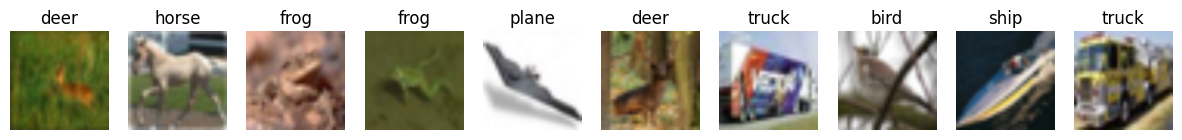

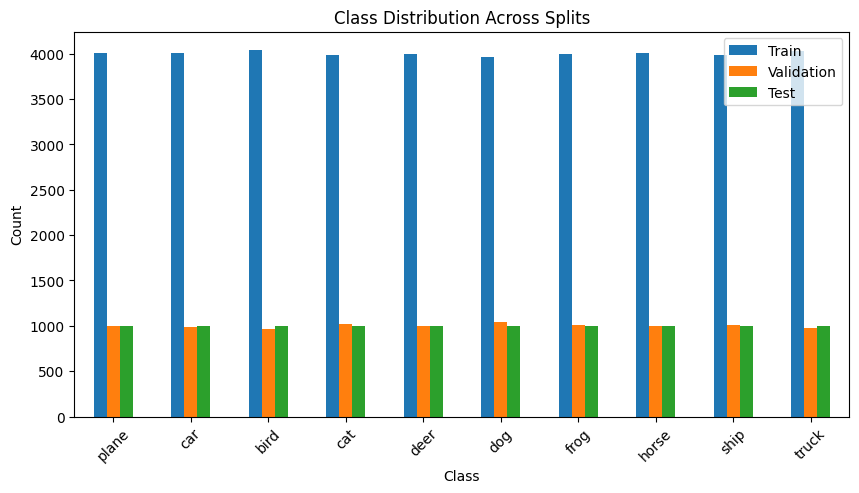


Class Distribution:
   Train  Validation  Test
0   4006         994  1000
1   4009         991  1000
2   4041         959  1000
3   3979        1021  1000
4   3999        1001  1000
5   3960        1040  1000
6   3992        1008  1000
7   4003         997  1000
8   3987        1013  1000
9   4024         976  1000


In [7]:
# Test Step 1
data_loader = CIFAR10DataLoader()
print("Data loaders created successfully!")
print(f"Train batches: {len(data_loader.trainloader)}")
print(f"Val batches: {len(data_loader.valloader)}")
print(f"Test batches: {len(data_loader.testloader)}")

# Visualize samples and class distribution
data_loader.visualize_samples()
class_dist = data_loader.get_class_distribution()
print("\nClass Distribution:")
print(class_dist)

## Step 2: Base Model Setup

In [20]:
import torch.nn as nn
import torchvision

class TransferModel(nn.Module):
    def __init__(self, base_model, head):
        super().__init__()
        self.base_model = base_model
        self.head = head
        # Add proper feature extraction
        self.features = nn.Sequential(
            base_model.features,
            nn.AdaptiveAvgPool2d((1, 1))
        )

    def forward(self, x):
        x = self.features(x)  # Output: (batch, 1280, 1, 1)
        return self.head(x)

from torchvision.models import MobileNet_V2_Weights

class ModelBuilder:
    def __init__(self, num_classes=10, unfreeze_layers=7):
        self.num_classes = num_classes
        self.unfreeze_layers = unfreeze_layers

    def modify_stem(self, model):
        """Modify first conv layer for CIFAR-10's 32x32 input"""
        model.features[0][0] = nn.Conv2d(
            3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        model.features[0][1] = nn.BatchNorm2d(32)
        return model

    def get_base_model(self):
        """Get MobileNetV2 with modified stem and removed classifier"""
        model = torchvision.models.mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
        model = self.modify_stem(model)
        model.classifier = nn.Identity()
        return model

    def create_head(self, norm_type='batch'):
        """Create classification head with specified normalization"""
        layers = [
            nn.Flatten(),
            nn.Linear(1280, 512),
            nn.BatchNorm1d(512) if norm_type == 'batch' else nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, self.num_classes)
        ]
        return nn.Sequential(*layers)

    def build_model(self, norm_type='batch'):  # This is the correct method name
        """Build complete transfer learning model"""
        base_model = self.get_base_model()
        head = self.create_head(norm_type)
        model = TransferModel(base_model, head)

        # Unfreeze specified layers
        total_blocks = len(model.base_model.features)
        for i in range(total_blocks - self.unfreeze_layers, total_blocks):
            for param in model.base_model.features[i].parameters():
                param.requires_grad = True

        return model

In [27]:
# Test the implementation
print("Building model...")
builder = ModelBuilder()
model = builder.build_baseline_model()
print("Model built successfully!")

Building model...
Model built successfully!


In [28]:
# Test forward pass
print("\nTesting forward pass...")
test_input = torch.randn(2, 3, 224, 224)  # Batch of 2 images
print(f"Input shape: {test_input.shape}")


Testing forward pass...
Input shape: torch.Size([2, 3, 224, 224])


In [29]:
output = model(test_input)
print(f"\nFinal output shape: {output.shape}")


Final output shape: torch.Size([2, 10])


In [30]:
# Verify gradient flow
output.sum().backward()
print("\nGradients in base model (should be None for most):")
for name, param in model.base_model.named_parameters():
    if param.grad is not None:
        print(f"{name}: gradient exists")

print("\nGradients in adaptation head:")
for name, param in model.adaptation_head.named_parameters():
    if param.grad is not None:
        print(f"{name}: gradient exists")


Gradients in base model (should be None for most):

Gradients in adaptation head:
1.weight: gradient exists
1.bias: gradient exists
2.weight: gradient exists
2.bias: gradient exists
5.weight: gradient exists
5.bias: gradient exists


## Step 3: Implementing Normalization Variants

In [7]:
class BatchNormHead(nn.Module):
    def __init__(self, input_features=1280, hidden_size=256, dropout_rate=0.5, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(input_features, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        # x should be (batch, 1280, 1, 1)
        x = x.flatten(1)  # Flatten to (batch, 1280)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [8]:
class LayerNormHead(nn.Module):
    def __init__(self, input_features=1280, hidden_size=256, dropout_rate=0.5, num_classes=10):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_features, hidden_size)
        self.ln1 = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.ln1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [9]:
class FilterResponseNorm(nn.Module):
    def __init__(self, num_features, epsilon=1e-6):
        super(FilterResponseNorm, self).__init__()
        self.epsilon = epsilon
        self.weight = nn.Parameter(torch.ones(1, num_features, 1, 1))
        self.bias = nn.Parameter(torch.zeros(1, num_features, 1, 1))
        self.tau = nn.Parameter(torch.zeros(1, num_features, 1, 1))

    def forward(self, x):
        # Compute mean and variance per channel
        nu2 = torch.mean(x.pow(2), dim=(2, 3), keepdim=True)
        x = x * torch.rsqrt(nu2 + self.epsilon)
        return torch.max(self.weight * x + self.bias, self.tau)

In [10]:
class FRNHead(nn.Module):
    def __init__(self, input_features=1280, hidden_size=256, dropout_rate=0.5, num_classes=10):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_features, hidden_size)
        self.frn = FilterResponseNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = x.unsqueeze(-1).unsqueeze(-1)  # Add spatial dims for FRN
        x = self.frn(x)
        x = x.squeeze(-1).squeeze(-1)  # Remove spatial dims
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [38]:
class HeadFactory:
    @staticmethod
    def create_head(norm_type, input_features=1280, hidden_size=256, dropout_rate=0.5, num_classes=10):
        if norm_type == 'batch':
            return BatchNormHead(input_features, hidden_size, dropout_rate, num_classes)
        elif norm_type == 'layer':
            return LayerNormHead(input_features, hidden_size, dropout_rate, num_classes)
        elif norm_type == 'frn':
            return FRNHead(input_features, hidden_size, dropout_rate, num_classes)
        else:
            raise ValueError(f"Unsupported normalization type: {norm_type}")

In [36]:
# Test Step 3
test_input = torch.randn(2, 1280, 1, 1)  # Mock MobileNetV2 output

In [38]:
# Test BatchNorm head
bn_head = HeadFactory.create_head('batch')
output = bn_head(test_input)
print("\nBatchNorm head output shape:", output.shape)


BatchNorm head output shape: torch.Size([2, 10])


In [39]:
# Test LayerNorm head
ln_head = HeadFactory.create_head('layer')
output = ln_head(test_input)
print("LayerNorm head output shape:", output.shape)

LayerNorm head output shape: torch.Size([2, 10])


In [40]:
# Test FRN head
frn_head = HeadFactory.create_head('frn')
output = frn_head(test_input)
print("FRN head output shape:", output.shape)

FRN head output shape: torch.Size([2, 10])


In [41]:
# Test gradient flow for all heads
for head in [bn_head, ln_head, frn_head]:
    output = head(test_input)
    output.sum().backward()
    print(f"\nGradients in {head.__class__.__name__}:")
    for name, param in head.named_parameters():
        if param.grad is not None:
            print(f"{name}: gradient exists")


Gradients in BatchNormHead:
fc1.weight: gradient exists
fc1.bias: gradient exists
bn1.weight: gradient exists
bn1.bias: gradient exists
fc2.weight: gradient exists
fc2.bias: gradient exists

Gradients in LayerNormHead:
fc1.weight: gradient exists
fc1.bias: gradient exists
ln1.weight: gradient exists
ln1.bias: gradient exists
fc2.weight: gradient exists
fc2.bias: gradient exists

Gradients in FRNHead:
fc1.weight: gradient exists
fc1.bias: gradient exists
frn.weight: gradient exists
frn.bias: gradient exists
frn.tau: gradient exists
fc2.weight: gradient exists
fc2.bias: gradient exists


## Step 4: Gradient Analysis Infrastructure

In [11]:
class GradientTracker:
    def __init__(self, model):
        self.model = model
        self.gradients = {}
        self.handles = []

        # Track these specific layers in our architecture
        self.tracked_layers = [
            'base_model.features.0.0',    # First conv layer
            'base_model.features.18.0',  # Last conv block
            'adaptation_head.2',         # First Linear (1280->256)
            'adaptation_head.6'          # Final Linear (256->10)
        ]
        self._register_hooks()

    def _register_hooks(self):
        for name, module in self.model.named_modules():
            if name in self.tracked_layers:
                handle = module.register_backward_hook(self._make_hook(name))
                self.handles.append(handle)

    def _make_hook(self, name):
        def hook(module, grad_input, grad_output):
            self.gradients[name] = grad_output[0].detach().clone()
        return hook

    def get_gradients(self):
        return self.gradients

    def reset(self):
        self.gradients = {}

    def close(self):
        for handle in self.handles:
            handle.remove()

def train_with_clipping(model, train_loader, optimizer, criterion, clip_value=None, device='cuda', max_batches=5):
    model.train()
    tracker = GradientTracker(model)
    gradients = {}  # Store gradients here

    for i, (inputs, labels) in enumerate(train_loader):
        if i >= max_batches:
            break

        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        if clip_value is not None:
            nn.utils.clip_grad_norm_(model.parameters(), clip_value)

        optimizer.step()
        gradients.update(tracker.get_gradients())  # Capture gradients
        tracker.reset()

    tracker.close()
    return gradients

In [12]:
def train_with_clipping(model, train_loader, optimizer, criterion, clip_value=None, device='cuda'):
    model.train()
    tracker = GradientTracker(model)
    gradients = {}

    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        if clip_value is not None:
            nn.utils.clip_grad_norm_(model.parameters(), clip_value)

        optimizer.step()
        gradients.update(tracker.get_gradients())
        tracker.reset()

    tracker.close()
    return gradients

In [65]:
# 1. Model setup
model = ModelBuilder().build_baseline_model().to('cuda')
model.unfreeze_specific_layers(['features.18'])  # Unfreeze last conv block

In [66]:
# 2. Training setup
optimizer = optim.Adam([
    {'params': model.base_model.parameters(), 'lr': 1e-5},  # Lower LR for base
    {'params': model.adaptation_head.parameters(), 'lr': 1e-3}
])
criterion = nn.CrossEntropyLoss()

In [67]:
# 3. Run training
grads_no_clip = train_with_clipping(model, test_loader, optimizer, criterion, clip_value=None)
grads_with_clip = train_with_clipping(model, test_loader, optimizer, criterion, clip_value=1.0)

Training: 100%|██████████| 4/4 [00:00<00:00, 10.64it/s]


In [68]:
# 4. Analysis
print("\nGradient Norm Comparison:")
for layer in ['base_model.features.18.0', 'adaptation_head.2']:
    if layer in grads_no_clip and layer in grads_with_clip:
        norm_no = grads_no_clip[layer].norm().item()
        norm_clip = grads_with_clip[layer].norm().item()
        change = 100*(norm_clip - norm_no)/norm_no  # More accurate calculation
        print(f"{layer}:")
        print(f"  No clip: {norm_no:.4f}")
        print(f"  Clipped: {norm_clip:.4f}")
        print(f"  Change: {change:+.1f}%")


Gradient Norm Comparison:
base_model.features.18.0:
  No clip: 1.8291
  Clipped: 1.6597
  Change: -9.3%
adaptation_head.2:
  No clip: 0.2018
  Clipped: 0.2078
  Change: +3.0%


In [13]:
def plot_gradient_distributions(grads_no_clip, grads_with_clip):
    plt.figure(figsize=(12, 6))

    # Layer names we want to visualize
    layers = ['base_model.features.18.0', 'adaptation_head.2']
    colors = ['#1f77b4', '#ff7f0e']

    for i, layer in enumerate(layers):
        if layer in grads_no_clip and layer in grads_with_clip:
            plt.subplot(1, 2, i+1)

            # Plot unclipped gradients
            grad_no_clip = grads_no_clip[layer].cpu().numpy().flatten()
            plt.hist(grad_no_clip, bins=50, alpha=0.6, color=colors[0],
                    label=f'No Clip (σ={np.std(grad_no_clip):.2e})')

            # Plot clipped gradients
            grad_clip = grads_with_clip[layer].cpu().numpy().flatten()
            plt.hist(grad_clip, bins=50, alpha=0.6, color=colors[1],
                    label=f'Clipped (σ={np.std(grad_clip):.2e})')

            plt.title(f'Gradient Distribution\n{layer.split(".")[-1]}')
            plt.xlabel('Gradient Value')
            plt.ylabel('Frequency')
            plt.yscale('log')  # Log scale for better visibility
            plt.legend()
            plt.grid(True, which="both", ls="-", alpha=0.2)

    plt.tight_layout()
    plt.show()

## Step 5: Training Framework

In [14]:
def train_model(model, train_loader, val_loader, optimizer, criterion,
               num_epochs=15, device='cuda', use_grad_clip=False,
               clip_value=1.0, gradient_tracker=None):

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            if use_grad_clip:
                nn.utils.clip_grad_norm_(model.parameters(), clip_value)

            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            if gradient_tracker:
                gradient_tracker.reset()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation phase
        val_loss, val_acc = validate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}: "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    return {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_acc': train_accs,
        'val_acc': val_accs
    }

def validate_model(model, val_loader, criterion, device='cpu'):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = running_loss / len(val_loader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

class ExperimentManager:
    def __init__(self, save_dir='./experiments'):
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)
        self.experiments = {}

    def run_experiment(self, name, model, train_loader, val_loader, **kwargs):
        print(f"\nRunning experiment: {name}")

        # Initialize gradient tracker
        gradient_tracker = GradientTracker(model) if kwargs.get('track_gradients', False) else None

        # Train
        results = train_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            optimizer=optim.Adam(model.parameters(), lr=kwargs.get('lr', 1e-3)),
            criterion=nn.CrossEntropyLoss(),
            num_epochs=kwargs.get('num_epochs', 15),
            device=kwargs.get('device', 'cpu'),
            use_grad_clip=kwargs.get('use_grad_clip', False),
            clip_value=kwargs.get('clip_value', 1.0),
            gradient_tracker=gradient_tracker
        )

        # Save gradients if tracked
        if gradient_tracker:
            results['gradients'] = gradient_tracker.get_gradients()

        self.experiments[name] = results
        self.save_results()
        return results

    def save_results(self):
        torch.save(self.experiments, os.path.join(self.save_dir, 'experiments.pt'))
        print(f"Results saved to {os.path.join(self.save_dir, 'experiments.pt')}")

    def load_results(self):
        path = os.path.join(self.save_dir, 'experiments.pt')
        if os.path.exists(path):
            self.experiments = torch.load(path)
            return self.experiments
        print(f"No saved results found at {path}")
        return None

##  Step 6: Loss Landscape Visualization

In [15]:
class LossLandscapeAnalyzer:
    def __init__(self, model, dataloader, criterion, device='cuda'):
        self.model = model.to(device)
        self.dataloader = dataloader
        self.criterion = criterion
        self.device = device

    def get_random_directions(self, model_params=None):
        """Generate random directions for perturbation"""
        if model_params is None:
            # Get only parameters that require grad
            model_params = [p for p in self.model.parameters() if p.requires_grad]

        directions = []
        for param in model_params:
            if param is not None and param.requires_grad:
                directions.append(torch.randn_like(param))
        return directions

    def compute_loss_landscape(self, alpha_range=(-1, 1), beta_range=(-1, 1),
                             steps=10, direction1=None, direction2=None):
        # Get directions if not provided
        if direction1 is None or direction2 is None:
            direction1 = self.get_random_directions()
            direction2 = self.get_random_directions()

        # Original parameters
        original_params = [p.clone() for p in self.model.parameters() if p is not None]

        # Create grid
        alphas = torch.linspace(alpha_range[0], alpha_range[1], steps)
        betas = torch.linspace(beta_range[0], beta_range[1], steps)
        landscape = torch.zeros(steps, steps)

        # Compute loss at each point
        for i, alpha in enumerate(alphas):
            for j, beta in enumerate(betas):
                # Perturb parameters
                for idx, param in enumerate(self.model.parameters()):
                    if param is not None and param.requires_grad:
                        param.data = original_params[idx] + alpha * direction1[idx] + beta * direction2[idx]

                # Compute loss
                running_loss = 0.0
                with torch.no_grad():
                    for inputs, labels in self.dataloader:
                        inputs, labels = inputs.to(self.device), labels.to(self.device)
                        outputs = self.model(inputs)
                        loss = self.criterion(outputs, labels)
                        running_loss += loss.item()

                landscape[i, j] = running_loss / len(self.dataloader)

        # Restore original parameters
        for idx, param in enumerate(self.model.parameters()):
            if param is not None and param.requires_grad:
                param.data = original_params[idx]

        return landscape, alphas, betas

    def compute_head_loss_landscape(self, steps=10):
        """Focus on adaptation head parameters only"""
        head_params = []
        for name, param in self.model.named_parameters():
            if 'adaptation_head' in name and param is not None:
                head_params.append(param)

        direction1 = self.get_random_directions(head_params)
        direction2 = self.get_random_directions(head_params)

        return self.compute_loss_landscape(
            steps=steps,
            direction1=direction1,
            direction2=direction2
        )

 ## Step 7: Running Experiments

## Step 8: Analysis and Visualization

In [32]:
from torchvision import datasets, transforms
import torch.nn.functional as F

In [37]:
def run_step7_experiments():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    builder = ModelBuilder(num_classes=10, unfreeze_layers=7)
    os.makedirs('./step7_results', exist_ok=True)

    # Data loading with augmentation
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])

    train_loader = DataLoader(
        datasets.CIFAR10('./data', train=True, download=True, transform=train_transform),
        batch_size=128, shuffle=True, num_workers=2)

    val_loader = DataLoader(
        datasets.CIFAR10('./data', train=False,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
                       ])),
        batch_size=128, shuffle=False, num_workers=2)

    experiment_configs = [
        {'name': 'batchnorm_no_clip', 'norm_type': 'batch', 'use_grad_clip': False},
        {'name': 'batchnorm_clip', 'norm_type': 'batch', 'use_grad_clip': True, 'clip_value': 1.0},
        {'name': 'layernorm_no_clip', 'norm_type': 'layer', 'use_grad_clip': False},
        {'name': 'layernorm_clip', 'norm_type': 'layer', 'use_grad_clip': True, 'clip_value': 1.0},
        {'name': 'frn_no_clip', 'norm_type': 'frn', 'use_grad_clip': False},
        {'name': 'frn_clip', 'norm_type': 'frn', 'use_grad_clip': True, 'clip_value': 1.0},
    ]

    # Initialize gradient tracker
    gradient_stats = {}

    # Prepare plots
    plt.figure(figsize=(18, 12))
    ax1 = plt.subplot(2, 3, 1)  # Loss curves
    ax2 = plt.subplot(2, 3, 2)  # Accuracy curves
    ax3 = plt.subplot(2, 3, 3)  # Gradient norms
    ax4 = plt.subplot(2, 3, 4)  # Landscape visualization 1
    ax5 = plt.subplot(2, 3, 5)  # Landscape visualization 2
    ax6 = plt.subplot(2, 3, 6)  # Landscape visualization 3

    for config in experiment_configs:
        print(f"\n=== Running {config['name']} ===")
        model = builder.build_model(norm_type=config['norm_type']).to(device)

        # Initialize trackers
        train_losses = []
        val_losses = []
        train_accs = []
        val_accs = []
        grad_norms = []

        optimizer = optim.AdamW([
            {'params': model.base_model.parameters(), 'lr': 3e-4},
            {'params': model.head.parameters(), 'lr': 1e-3}
        ], weight_decay=1e-4)

        # Training loop with tqdm
        best_val_acc = 0
        epoch_pbar = tqdm(range(25), desc="Training Progress", position=0)
        for epoch in epoch_pbar:
            model.train()
            epoch_train_loss = 0
            correct = 0
            total = 0
            grad_norm = 0

            # Training phase with progress bar
            train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/25 - Training", leave=False, position=1)
            for inputs, labels in train_pbar:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = F.cross_entropy(outputs, labels)
                loss.backward()

                # Track gradient statistics
                total_grad_norm = 0
                for p in model.parameters():
                    if p.grad is not None:
                        total_grad_norm += p.grad.norm().item()
                grad_norm += total_grad_norm

                if config['use_grad_clip']:
                    nn.utils.clip_grad_norm_(model.parameters(), config['clip_value'])

                optimizer.step()

                epoch_train_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                # Update training progress bar
                train_pbar.set_postfix({
                    'loss': f"{epoch_train_loss/(train_pbar.n+1):.4f}",
                    'acc': f"{100.*correct/total:.2f}%"
                })

            # Validation phase with progress bar
            model.eval()
            val_loss = 0
            val_correct = 0
            val_total = 0

            val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/25 - Validation", leave=False, position=1)
            with torch.no_grad():
                for inputs, labels in val_pbar:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    val_loss += F.cross_entropy(outputs, labels).item()
                    _, predicted = outputs.max(1)
                    val_total += labels.size(0)
                    val_correct += predicted.eq(labels).sum().item()

                    # Update validation progress bar
                    val_pbar.set_postfix({
                        'val_loss': f"{val_loss/(val_pbar.n+1):.4f}",
                        'val_acc': f"{100.*val_correct/val_total:.2f}%"
                    })

            # Save metrics
            train_loss = epoch_train_loss/len(train_loader)
            val_loss = val_loss/len(val_loader)
            train_acc = 100.*correct/total
            val_acc = 100.*val_correct/val_total

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            grad_norms.append(grad_norm/len(train_loader))

            # Update epoch progress bar
            epoch_pbar.set_postfix({
                'train_loss': f"{train_loss:.4f}",
                'train_acc': f"{train_acc:.2f}%",
                'val_loss': f"{val_loss:.4f}",
                'val_acc': f"{val_acc:.2f}%",
                'grad_norm': f"{grad_norms[-1]:.2f}"
            })

            # Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': val_loss,
                    'acc': val_acc
                }, f"./step7_results/{config['name']}_best.pth")

        # Close nested progress bars
        train_pbar.close()
        val_pbar.close()

        # Save final model and logs
        torch.save({
            'model_state_dict': model.state_dict(),
            'config': config,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accs': train_accs,
            'val_accs': val_accs,
            'grad_norms': grad_norms
        }, f"./step7_results/{config['name']}_final.pth")

        # Plot training curves
        ax1.plot(train_losses, label=f"{config['name']} Train")
        ax1.plot(val_losses, '--', label=f"{config['name']} Val")
        ax2.plot(train_accs, label=f"{config['name']} Train")
        ax2.plot(val_accs, '--', label=f"{config['name']} Val")
        ax3.plot(grad_norms, label=config['name'])

        # Compute and save loss landscape
        try:
            analyzer = LossLandscapeAnalyzer(model, val_loader, nn.CrossEntropyLoss(), device)
            landscape, alphas, betas = analyzer.compute_head_loss_landscape(steps=15)

            torch.save({
                'landscape': landscape,
                'alphas': alphas,
                'betas': betas
            }, f"./step7_results/{config['name']}_landscape.pt")

            # Visualize selected landscapes
            if config['norm_type'] == 'batch':
                ax4.contourf(alphas.cpu(), betas.cpu(), landscape.cpu(), levels=20, cmap='viridis')
                ax4.set_title(f"BatchNorm Landscape")
            elif config['norm_type'] == 'layer':
                ax5.contourf(alphas.cpu(), betas.cpu(), landscape.cpu(), levels=20, cmap='viridis')
                ax5.set_title(f"LayerNorm Landscape")
            elif config['norm_type'] == 'frn':
                ax6.contourf(alphas.cpu(), betas.cpu(), landscape.cpu(), levels=20, cmap='viridis')
                ax6.set_title(f"FRN Landscape")

        except Exception as e:
            print(f"Error computing landscape: {str(e)}")

    # Finalize plots
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid()

    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid()

    ax3.set_title('Gradient Norms During Training')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Gradient Norm')
    ax3.legend()
    ax3.grid()

    plt.tight_layout()
    plt.savefig('./step7_results/training_analysis.png')
    plt.close()

    print("\nAll experiments completed!")
    print("Saved results to ./step7_results/")

In [38]:
# Run with error handling
try:
    run_step7_and_8_experiments()
    plot_all_loss_curves()  # Visualize results
except Exception as e:
    print(f"Error running experiments: {str(e)}")


=== Running batchnorm_no_clip ===
Epoch 1: Train Loss: 1.1017 | Train Acc: 61.00% | Val Loss: 0.7745 | Val Acc: 73.73% | Grad Norm: 47.77
Epoch 2: Train Loss: 0.7191 | Train Acc: 75.23% | Val Loss: 0.6021 | Val Acc: 79.43% | Grad Norm: 36.26
Epoch 3: Train Loss: 0.5811 | Train Acc: 79.85% | Val Loss: 0.5386 | Val Acc: 81.14% | Grad Norm: 34.33
Epoch 4: Train Loss: 0.4952 | Train Acc: 82.98% | Val Loss: 0.4601 | Val Acc: 83.92% | Grad Norm: 33.05
Epoch 5: Train Loss: 0.4350 | Train Acc: 84.89% | Val Loss: 0.4219 | Val Acc: 85.09% | Grad Norm: 32.43
Epoch 6: Train Loss: 0.3914 | Train Acc: 86.43% | Val Loss: 0.3978 | Val Acc: 86.35% | Grad Norm: 32.08
Epoch 7: Train Loss: 0.3559 | Train Acc: 87.72% | Val Loss: 0.3758 | Val Acc: 87.25% | Grad Norm: 31.38
Epoch 8: Train Loss: 0.3269 | Train Acc: 88.83% | Val Loss: 0.3585 | Val Acc: 87.70% | Grad Norm: 30.77
Epoch 9: Train Loss: 0.2987 | Train Acc: 89.65% | Val Loss: 0.3406 | Val Acc: 88.42% | Grad Norm: 30.65
Epoch 10: Train Loss: 0.2739 